# Sentiment Analysis on Voice Anomalies in Telephone Conversations

## Import Packages and Libraries

In [1]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import os
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Input, Flatten, Dropout, Activation
from tensorflow.keras.utils import to_categorical
import np_utils
from tensorflow.keras import optimizers

Populating the interactive namespace from numpy and matplotlib


## Data Set Preparing

In [2]:
mylist = []
for path, subdirs, files in os.walk("data"):
    for name in files:
        mylist.append(os.path.join(path, name))

## Waveform of an Audio File

In [3]:
data, sampling_rate = librosa.load("data/Actor_02/03-01-06-01-01-01-02.wav")

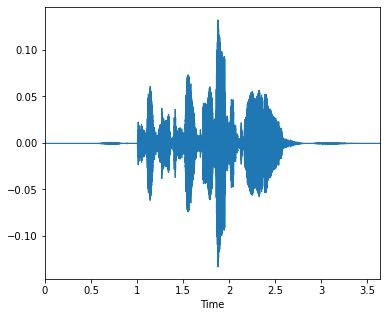

In [4]:
plt.figure(figsize=(6, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## Spectrogram

C:\Users\ertug\AppData\Local\Temp/ipykernel_5012/2589888366.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read("data/Actor_02/03-01-06-01-01-01-02.wav")
C:\Users\ertug\AppData\Local\Temp/ipykernel_5012/2589888366.py:12: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


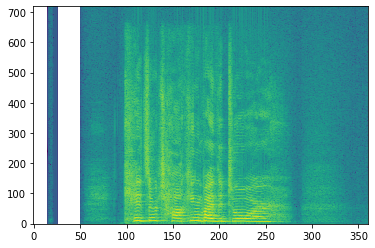

In [5]:
sr,x = scipy.io.wavfile.read("data/Actor_02/03-01-06-01-01-01-02.wav")
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()
#plt.savefig('spectrogram.png')

## Extract Features from Audio Using "Librosa"

In [6]:
"""
In this step, according to the emotion of data, we define a label. This class takes a file path and according to its name :
the function find its gender and emotion and label it.
"""

def get_emotion(file_path):
        item = file_path.split('\\')[-1]
        if item[6:-16]=='02' and int(item[18:-4])%2==0:
            return 'female_calm'
        elif item[6:-16]=='02' and int(item[18:-4])%2==1:
            return 'male_calm'
        elif item[6:-16]=='03' and int(item[18:-4])%2==0:
            return 'female_happy'
        elif item[6:-16]=='03' and int(item[18:-4])%2==1:
            return 'male_happy'
        elif item[6:-16]=='04' and int(item[18:-4])%2==0:
            return 'female_sad'
        elif item[6:-16]=='04' and int(item[18:-4])%2==1:
            return 'male_sad'
        elif item[6:-16]=='05' and int(item[18:-4])%2==0:
            return 'female_angry'
        elif item[6:-16]=='05' and int(item[18:-4])%2==1:
            return 'male_angry'
        elif item[6:-16]=='06' and int(item[18:-4])%2==0:
            return 'female_fearful'
        elif item[6:-16]=='06' and int(item[18:-4])%2==1:
            return 'male_fearful'
        elif item[6:-16]=='01' and int(item[18:-4])%2==0:
            return 'female_neutral'
        elif item[6:-16]=='01' and int(item[18:-4])%2==1:
            return 'male_neutral'
        elif item[6:-16]=='07' and int(item[18:-4])%2==0:
            return 'female_disgusted'
        elif item[6:-16]=='07' and int(item[18:-4])%2==1:
            return 'male_disgusted'
        elif item[6:-16]=='08' and int(item[18:-4])%2==0:
            return 'female_surprised'
        elif item[6:-16]=='08' and int(item[18:-4])%2==1:
            return 'male_surprised'
        elif item[:1]=='a':
            return 'male_angry'
        elif item[:1]=='h':
            return 'male_happy'
        elif item[:1]=='n':
            return 'male_neutral'
        elif item[:2]=='sa':
            return 'male_sad'

In [7]:
# In this step, by using librosa, we extract the feature and emotion of data and store them in a dataframe named 'df'.

df = pd.DataFrame(columns=['feature','emotion'])
bookmark=0
for index,y in enumerate(mylist):
    X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs # audio data features kept here
    emotion = get_emotion(y) # audio data emotions kept here
    df.loc[bookmark] = [feature, emotion]
    bookmark=bookmark+1 

## Train and Test Sets Preparing

In [8]:
feature_df = pd.DataFrame(df['feature'].values.tolist()) # obtaining features individually as a list
labelled_df = pd.concat([feature_df,df['emotion']], axis=1) # concatanate the labels (emotions) to feature
df_cleaned = labelled_df.fillna(0) # delete 'NaN' values and fill them with '0'.
shuffled_df = df_cleaned.sample(frac=1).reset_index(drop=True)
shuffled_df = shuffled_df.loc[~shuffled_df['emotion'].isin(['male_neutral', 'male_disgusted', 'male_surprised', 'female_neutral', 'female_disgusted', 'female_surprised'])]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis =1), shuffled_df['emotion'], test_size=0.2, random_state=0, shuffle = True)

In [10]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [11]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

## Sentiment Analysis Model

In [12]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(x_train_exp.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 128)          768       
                                                                 
 activation (Activation)     (None, 259, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 128)          82048     
                                                                 
 activation_1 (Activation)   (None, 259, 128)          0         
                                                                 
 dropout (Dropout)           (None, 259, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 128)          0         
 )                                                               
                                                        

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
history=model.fit(x_train_exp, y_train, batch_size=16, epochs=700, validation_data=(x_test_exp, y_test), verbose=0)

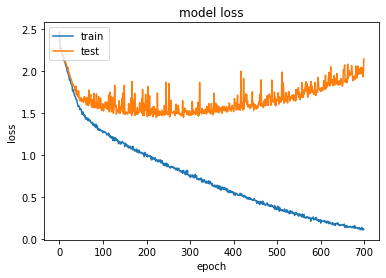

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('result.png')

In [17]:
train_result = model.evaluate(x_train_exp, y_train, verbose=1)
test_result = model.evaluate(x_test_exp, y_test, verbose=1)

print("train acc","%s: %.2f%%" % (model.metrics_names[1], train_result[1]*100))
print("test acc","%s: %.2f%%" % (model.metrics_names[1], test_result[1]*100))

7/7 [==============================] - 0s 11ms/step - loss: 2.1433 - accuracy: 0.4456
train acc accuracy: 98.44%
test acc accuracy: 44.56%


## Save the Model

In [18]:
model_name = 'Sentiment_Analysis_On_Voice_Anomalies_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

In [19]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Load the Model

In [20]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Sentiment_Analysis_On_Voice_Anomalies_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_test_exp, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 44.56%


## Test the Predictions

In [21]:
preds = loaded_model.predict(x_test_exp, batch_size=512, verbose=1)

preds_mod = preds.argmax(axis=1)
preds_flat = preds_mod.astype(int).flatten()
preds_transformed = (lb.inverse_transform((preds_flat)))
pred_df = pd.DataFrame({'predictedvalues': preds_transformed})

actual_values = y_test.argmax(axis=1)
actual_values_mod = actual_values.astype(int).flatten()
actual_values_mod_transformed = (lb.inverse_transform((actual_values_mod)))
actual_df = pd.DataFrame({'actualvalues': actual_values_mod_transformed})

final_df = actual_df.join(pred_df)
final_df.head(10)

1/1 [==============================] - 0s 153ms/step


,actualvalues,predictedvalues
0,male_angry,male_angry
1,male_fearful,male_fearful
2,female_angry,female_angry
3,female_angry,female_sad
4,female_fearful,female_happy
5,male_happy,male_fearful
6,female_happy,female_calm
7,female_sad,female_sad
8,male_calm,male_calm
9,female_sad,female_sad


## New Voice Data Sentiment Analysis

In [22]:
def new_voice_sent_analyze(filename):
    new_data, new_sampling_rate = librosa.load('data\\Actor_'+filename[18:-4]+'\\'+filename, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
    new_sampling_rate = np.array(new_sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=new_data, sr=new_sampling_rate, n_mfcc=13), axis=0)
    feature = mfccs
    emotion = get_emotion(y)
    new_df=feature
    
    new_df= pd.DataFrame(data=new_df)
    new_df = new_df.stack().to_frame().T
    twodim= np.expand_dims(new_df, axis=2)
    
    new_voice_prediction = loaded_model.predict(twodim, batch_size=32, verbose=0)
    new_voice_prediction1=new_voice_prediction.argmax(axis=1)
    new_voice_prediction1=new_voice_prediction.argmax(axis=1)
    new_voice_predictions = (lb.inverse_transform((new_voice_prediction1.astype(int).flatten())))
    return str(new_voice_predictions[0])

## Detecting the location of a phone number

In [23]:
import phonenumbers
from phonenumbers import geocoder
from opencage.geocoder import OpenCageGeocode

In [24]:
Key = '...' # Obtain a key for using OpenCage
geocoder = OpenCageGeocode(Key)

In [25]:
def locationDetector(phone_number):
    phone_number=phonenumbers.parse(phone_number)
    number_location = phonenumbers.geocoder.description_for_number(phone_number, "en")
    query = str(number_location)
    results = geocoder.geocode(query)
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']
    loc_array = [lat,long]
    return loc_array

In [26]:
locationDetector("...") # Phone number was deleted for privacy!

[38.9597594, 34.9249653]

## Sending a message to a gsm number

In [27]:
#pip install twilio 

"""
We used twilio to send a message to a gsm number. First, we create a free account then apply following code:
"""
from twilio.rest import Client

account_sid = '...'  # SID was deleted for privacy!
auth_token = '...' # Token was deleted for privacy!

In [28]:
def send_message(phone_number, message):
    # instantiating the Client
    user = Client(account_sid, auth_token)

    #twilio phone number that will send the message:
    phonenum = '...'  # Phone number was deleted for privacy! Obtain a phonenumber from Twilio!

    # sending message
    message = user.messages.create(body=message, from_=phonenum, to=phone_number)

## Final Implementation of Sentiment Analysis

In [29]:
#pip install folium

In [30]:
import folium # it's used for visualizing location on map
from IPython.display import IFrame

In [31]:
def final_implementation(voice_data, customer_number, third_party_org_num):
    voice_detected = new_voice_sent_analyze(voice_data)
    #print("Detected Emotion from Voice:",voice_detected)

    """
    voice_detected[7:] # for female
    voice_detected[5:] # for male
    """

    if(voice_detected[7:] == 'fearful' or voice_detected[5:] == 'fearful'): # if the emotion is 'fearful' for both male and female custommer
        location = locationDetector(customer_number) # detect the location using 'locationDetector' method
        location_info = 'lat:' + str(location[0]) + "  long:"+ str(location[1]) # extract location lat. ang long. info
        text = "The instruction I have given now is not voluntary. I request that the transactions be stopped and help be sent to me! "
        message = text + "My location info: " + location_info # create a message including text and location info
        send_message(third_party_org_num,message) # send the message to third party organization that customer talks with
        
        # to create a visual for location on map, following code block was written. Folium library was used.
        cust_loc_map = folium.Map(location=[location[0],location[1]], zoom_start=9) # create the map using lat. and long. of customer loc.
        folium.Marker([location[0],location[1]]).add_to((cust_loc_map)) # add a marker of exact location
        cust_loc_map.save("CustomerLocation.html") # the map was saved as 'html'

In [32]:
final_implementation('03-01-06-01-01-01-01.wav','+905555678899','+905555678890') #Phonenumber are sample phone number. We used real one in our implementation.

In [33]:
# let's see the map on kernel
IFrame(src="CustomerLocation.html", width=700, height=600)